<a href="https://colab.research.google.com/github/kurtsenol/machine-learning/blob/master/TopicModeling/Methodology/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
!pip install pyLDAvis

In [ ]:
!pip3 install pickle5

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle5 as pickle
from pprint import pprint

## Dataset

Below is our dataset:

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/df_all_final.pkl", "rb") as fh:
  df = pickle.load(fh)

In [ ]:
df

,JO,AU,TI,PY,DI,urls,filename,methodology
0,IJCHM,"Ineson, EM; Comic, D; Kalmic, L",Towards a hierarchy of hotel guests' in-room n...,2019.0,10.1108/IJCHM-01-2019-0061,https://www.emerald.com/insight/content/doi/10...,IJCHM_0.txt,Methodology\nThe design is qualitative and exp...
1,IJCHM,"Benitez-Aurioles, B",Barcelona's peer-to-peer tourist accommodation...,2019.0,10.1108/IJCHM-01-2019-0090,https://www.emerald.com/insight/content/doi/10...,IJCHM_1.txt,Data\nThere are no official statistics on the ...
2,IJCHM,"Hu, XB; Yang, Y; Park, S",A meta-regression on the effect of online rati...,2019.0,10.1108/IJCHM-10-2018-0835,https://www.emerald.com/insight/content/doi/10...,IJCHM_2.txt,3. Research method\nWe searched the empirical ...
3,IJCHM,"Ahmat, NHC; Arendt, SW; Russell, DW",Examining work factors after Malaysia's minimu...,2019.0,10.1108/IJCHM-10-2018-0827,https://www.emerald.com/insight/content/doi/10...,IJCHM_3.txt,Methods\nParticipants\nEmployees from operatio...
4,IJCHM,"Kim, EL; Tanford, S",Seeking reward or avoiding risk from restauran...,2019.0,10.1108/IJCHM-03-2018-0235,https://www.emerald.com/insight/content/doi/10...,IJCHM_4.txt,Method\nDesign\nParticipants made dining decis...
...,...,...,...,...,...,...,...,...
3264,JHTR,"Kim, W; Ok, C",CUSTOMER ORIENTATION OF SERVICE EMPLOYEES AND ...,2010.0,10.1177/1096348009344234,NaN,NaN,\nMETHOD\nMeasures\nSignificant discrepant res...
3265,JHTR,"Gazzoli, G; Hancer, M; Park, Y",THE ROLE AND EFFECT OF JOB SATISFACTION AND EM...,2010.0,10.1177/1096348009344235,NaN,NaN,\nMETHOD\nSample and Data Collection\nBecause ...
3266,JHTR,"Young, CA; Corsun, DL","BURNED! THE IMPACT OF WORK ASPECTS, INJURY, AN...",2010.0,10.1177/1096348009349816,NaN,NaN,\nMETHOD\nData Collection\nManagement from 13 ...
3267,JHTR,"Kim, DY; Wen, L; Doh, K",DOES CULTURAL DIFFERENCE AFFECT CUSTOMER'S RES...,2010.0,10.1177/1096348009349817,NaN,NaN,\nMETHOD\nSample\nAn experimental design was e...


The dataset includes **3269** articles from **5 journals**.

In [ ]:
df.dropna(subset=["methodology"], inplace=True)

In [ ]:
df

,JO,AU,TI,PY,DI,urls,filename,methodology
0,IJCHM,"Ineson, EM; Comic, D; Kalmic, L",Towards a hierarchy of hotel guests' in-room n...,2019.0,10.1108/IJCHM-01-2019-0061,https://www.emerald.com/insight/content/doi/10...,IJCHM_0.txt,Methodology\nThe design is qualitative and exp...
1,IJCHM,"Benitez-Aurioles, B",Barcelona's peer-to-peer tourist accommodation...,2019.0,10.1108/IJCHM-01-2019-0090,https://www.emerald.com/insight/content/doi/10...,IJCHM_1.txt,Data\nThere are no official statistics on the ...
2,IJCHM,"Hu, XB; Yang, Y; Park, S",A meta-regression on the effect of online rati...,2019.0,10.1108/IJCHM-10-2018-0835,https://www.emerald.com/insight/content/doi/10...,IJCHM_2.txt,3. Research method\nWe searched the empirical ...
3,IJCHM,"Ahmat, NHC; Arendt, SW; Russell, DW",Examining work factors after Malaysia's minimu...,2019.0,10.1108/IJCHM-10-2018-0827,https://www.emerald.com/insight/content/doi/10...,IJCHM_3.txt,Methods\nParticipants\nEmployees from operatio...
4,IJCHM,"Kim, EL; Tanford, S",Seeking reward or avoiding risk from restauran...,2019.0,10.1108/IJCHM-03-2018-0235,https://www.emerald.com/insight/content/doi/10...,IJCHM_4.txt,Method\nDesign\nParticipants made dining decis...
...,...,...,...,...,...,...,...,...
3264,JHTR,"Kim, W; Ok, C",CUSTOMER ORIENTATION OF SERVICE EMPLOYEES AND ...,2010.0,10.1177/1096348009344234,NaN,NaN,\nMETHOD\nMeasures\nSignificant discrepant res...
3265,JHTR,"Gazzoli, G; Hancer, M; Park, Y",THE ROLE AND EFFECT OF JOB SATISFACTION AND EM...,2010.0,10.1177/1096348009344235,NaN,NaN,\nMETHOD\nSample and Data Collection\nBecause ...
3266,JHTR,"Young, CA; Corsun, DL","BURNED! THE IMPACT OF WORK ASPECTS, INJURY, AN...",2010.0,10.1177/1096348009349816,NaN,NaN,\nMETHOD\nData Collection\nManagement from 13 ...
3267,JHTR,"Kim, DY; Wen, L; Doh, K",DOES CULTURAL DIFFERENCE AFFECT CUSTOMER'S RES...,2010.0,10.1177/1096348009349817,NaN,NaN,\nMETHOD\nSample\nAn experimental design was e...


After dropping papers without methodology section, there remained **3076 papers**.

In [ ]:
df.groupby('JO')['methodology'].count().sort_values(ascending=False)

JO
IJHM     1299
IJCHM     932
JHTR      316
CHQ       309
JHMM      220
Name: methodology, dtype: int64

The number of articles per journal is as above: 

## Analysis

In [ ]:
# spacy for lemmatization
import spacy
nlp = spacy.load('en_core_web_md', disable=['ner'])

In [ ]:
papers = list(df.methodology.values)

In [ ]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [ ]:
len(stop_words)

326

In [ ]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

### Tokenize Sentences and Clean

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = papers
data_words = list(sent_to_words(data))

### Build the Bigram, Trigram Models and Lemmatize

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and len(token.text)>3])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    return texts_out

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
data_ready = process_words(data_words)  # processed Text Data!

Above we preprocess the corpus that includes: 
- removing stop words,
- doing lemmatization,
- implementing ngrams,
- selection of tokens based on speech of tags (*keep the words that are either noun, adjective, verb or adverb*)

In [ ]:
# from collections import Counter
# bi_grams = [w for list in data_ready for w in list if "_" in w]
# bi = Counter(bi_grams)
# [a for a,b in bi.most_common(40)]

In [ ]:
# import re
# subs = r"\w+_\w+_\w+"
# tri_grams = [w for list in data_ready for w in list if re.search(subs, w)]
# tri = Counter(tri_grams)
# [a for a,b in tri.most_common(30)]

In [ ]:
# l = ["uses", "use", "used", "using", "have used"]
# doc = nlp(" ".join(l))

# [a.lemma_ for a in doc]

### Create the Dictionary and Corpus needed for Topic Modeling

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 15557


After preprocessing step we form a dictionary that the model requires.

In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq


In [ ]:
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


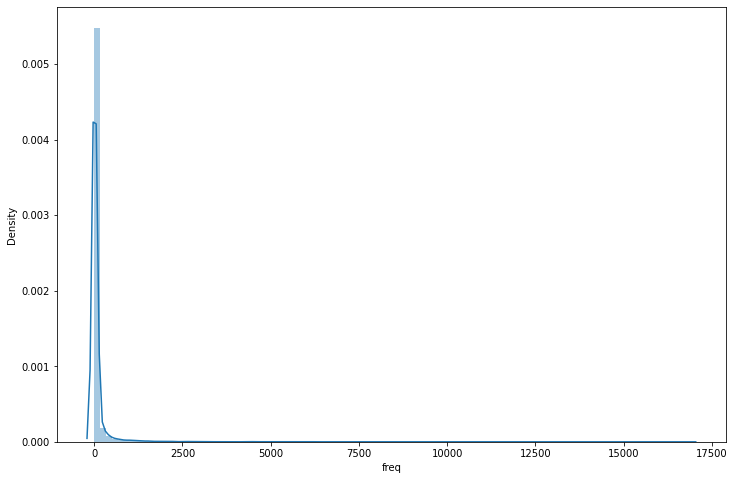

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.distplot(dict_df['freq'], bins=100);

Above is the graph for word frequencies of our dictionary, just to have general idea about the words and their frequencies. Most of the words have frequency values less than 500. 

Below you can find the list of high frequency words in descending order. We will add those words that appear 3000 times or  more to stop list and restart the preprocess step to get better topic clusters. As expected, sector specific and general writing words have high frequencies.  

In [ ]:
dict_df[dict_df.freq>3000].sort_values('freq', ascending=False).head(60)

,freq
study,16839
hotel,16214
item,16121
measure,12330
scale,9771
variable,9663
model,9005
datum,8819
sample,8785
respondent,8599


In [ ]:
extension = dict_df[dict_df.freq>3000].index.tolist()

In [ ]:
stop_words.update(extension)

In [ ]:
data_ready = process_words(data_words)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 15669


 After removing the high frequency words there remains **15669** words in our dictionary.

In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
#ids = [id2word.token2id[extension[i]] for i in range(len(extension))]

In [ ]:
#id2word.filter_tokens(bad_ids=ids)

Next, we removed all terms that appear in less than 5 documents and all
terms that occur in more than 50% of all the documents. We are interested in finding different themes and topics and not recurring themes.

In [ ]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.

id2word.filter_extremes(no_below=5, no_above=0.5)

print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 6045


After final step there are **6189** words in the dictionary.

In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
# pickle.dump(id2word, open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/id2word.pkl", "wb"))
# pickle.dump(corpus, open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/corpus.pkl", "wb"))
# pickle.dump(data_ready, open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/data_ready.pkl", "wb"))

In [ ]:
id2word = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/id2word.pkl", "rb"))
corpus = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/corpus.pkl", "rb"))
data_ready = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/TopicModeling/Methodology/data_ready.pkl", "rb"))


### Build the Topic Model

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2021-03-14 08:03:30--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  9.03MB/s    in 1.7s    

2021-03-14 08:03:32 (9.03 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

In [ ]:
mallet_path = '/content/mallet-2.0.8/bin/mallet'  

In [ ]:
iterations = [1000, 2000, 5000]
alphas = [0.01, 0.2, 1, 5, 50]
num_topics=[10,15,20,30,50]

In [ ]:
# num_topics=10

In [ ]:
for n in num_topics:
  for alpha in alphas:
    for i in iterations:
      ldamallet = gensim.models.wrappers.LdaMallet( mallet_path, corpus=corpus, num_topics=n, id2word=id2word, iterations=i, alpha=alpha, workers=16)

      coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
      coherence_ldamallet = coherence_model_ldamallet.get_coherence()
      print('\nCoherence Score: ', alpha, "\t", i, "\t", coherence_ldamallet)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.01 	 1000 	 0.49895744883439425


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.01 	 2000 	 0.46416915256761593


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.01 	 5000 	 0.4858674275690588


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.2 	 1000 	 0.5057105230050961


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.2 	 2000 	 0.49864588441134394


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.2 	 5000 	 0.5036666447069306


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  1 	 1000 	 0.4941252424542192


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  1 	 2000 	 0.5191145575951256


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  1 	 5000 	 0.5231024094776264


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  5 	 1000 	 0.5124197943636215


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  5 	 2000 	 0.5017077909257283


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  5 	 5000 	 0.5081812672083548


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  50 	 1000 	 0.49379378380025996


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  50 	 2000 	 0.5067224264281037


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  50 	 5000 	 0.503437235944266


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.01 	 1000 	 0.4966387821601723


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.01 	 2000 	 0.4951879400376132


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.01 	 5000 	 0.4935817473013597


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.2 	 1000 	 0.5235236238022659


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.2 	 2000 	 0.5229581496084597


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.2 	 5000 	 0.5038537053706499


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  1 	 1000 	 0.5316035111771471


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  1 	 2000 	 0.5140581978594783


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  1 	 5000 	 0.5297579122694862


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  5 	 1000 	 0.5189405812626041


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  5 	 2000 	 0.5429476025781669


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  5 	 5000 	 0.529753676272584


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  50 	 1000 	 0.5032046581915872


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  50 	 2000 	 0.5208126375690144


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  50 	 5000 	 0.5184493161058451


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.01 	 1000 	 0.48954133385776294


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.01 	 2000 	 0.4898014377400523


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.01 	 5000 	 0.4811900681953463


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.2 	 1000 	 0.5165320173854864


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.2 	 2000 	 0.526837539752687


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.2 	 5000 	 0.5192455462951318


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  1 	 1000 	 0.5250373226691515


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
for alpha in alphas:
  for i in iterations:
    ldamallet = gensim.models.wrappers.LdaMallet( mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, iterations=i, alpha=alpha, workers=16)

    coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
    print('\nCoherence Score: ', alpha, "\t", i, "\t", coherence_ldamallet)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.01 	 1000 	 0.4735612268462237


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.01 	 2000 	 0.4613007769738946


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.01 	 5000 	 0.49073706816367213


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.2 	 1000 	 0.5022945464365929


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.2 	 2000 	 0.5124312202226047


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  0.2 	 5000 	 0.5087270052144846


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  1 	 1000 	 0.519925614095324


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  1 	 2000 	 0.489299878854355


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  1 	 5000 	 0.501492418653045


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  50 	 1000 	 0.4801350047494646


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  50 	 2000 	 0.507700698398515


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)



Coherence Score:  50 	 5000 	 0.5010213658406316


In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, iterations=2000, alpha=0.2, workers=64)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, iterations=1000, alpha=1, workers=64)


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


Below you can find the 10 topics formed by the model. For each topic there are 10 terms and their relative weights next to it in descending order.

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False, num_topics=10))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('food', 0.04798673177923155),
   ('menu', 0.018280659725421543),
   ('dining', 0.012733806320832949),
   ('wine', 0.012236248042016033),
   ('attribute', 0.011683405509997236),
   ('consumer', 0.010983138302773426),
   ('order', 0.010651432783562148),
   ('quality', 0.009877453238735833),
   ('price', 0.008790196259098867),
   ('meal', 0.007887220123468165)]),
 (1,
  [('code', 0.013176039538184343),
   ('process', 0.01216946661700907),
   ('approach', 0.010126123587023262),
   ('qualitative', 0.010025466294905734),
   ('category', 0.009491982646682839),
   ('content', 0.008636395663683856),
   ('theme', 0.008334423787331274),
   ('case', 0.007861334514378895),
   ('data', 0.007750611493049614),
   ('focus', 0.006844695863991867)]),
 (2,
  [('market', 0.01645899314004818),
   ('size', 0.013401973611807432),
   ('control', 0.01314518397143521),
   ('asset', 0.011873463847687058),
   ('return', 0.011188691473361132),
   ('sale', 0.010662884114503723),
   ('financial', 0.010283813

### LDA Tuning: Finding the Optimal Number of Topics

In [ ]:
from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count=5, end_topic_count=50, step=5, cpus=1):
  models = []
  coherence_scores = []
  for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
    mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=corpus, num_topics=topic_nums,
                                                            id2word=dictionary, iterations=2000, workers=cpus, alpha=5/topic_nums)
      
    cv_coherence_model_mallet_lda = gensim. models.CoherenceModel (model=mallet_lda_model, corpus=corpus, texts=texts,
                                                                     dictionary=dictionary, coherence='c_v')
      
    coherence_score = cv_coherence_model_mallet_lda.get_coherence()
    coherence_scores.append(coherence_score)
    models.append(mallet_lda_model)
  return models, coherence_scores

* We build several topic models, with the number of topics ranging from 2 to 50.

In [ ]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=corpus, texts=data_ready, dictionary=id2word,
                                                               start_topic_count=5, end_topic_count=50, step=5, cpus=64)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
 10%|█         | 1/10 [04:21<39:09, 261.03s/it]/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7

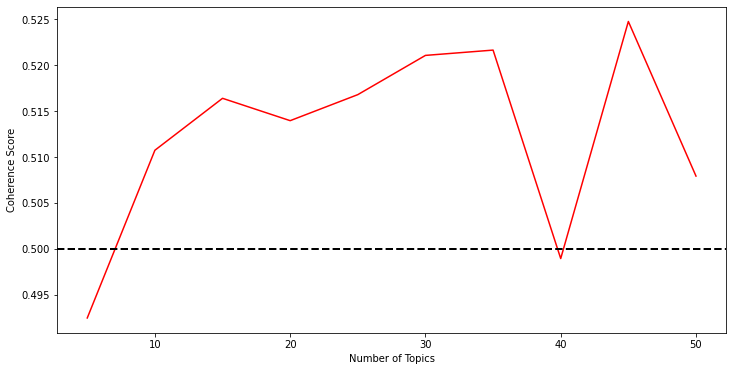

In [ ]:
x_ax = range(5, 51, 5)
y_ax = coherence_scores

plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')

plt.axhline(y=0.50, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'

xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

plt.show()

In [ ]:
coherence_df = pd.DataFrame({'Number of Topics': range(5, 51, 5), 'Coherence Score': np.round(coherence_scores, 4)})

coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
8,45,0.5247
6,35,0.5216
5,30,0.5211
4,25,0.5168
2,15,0.5164
3,20,0.5139
1,10,0.5107
9,50,0.5079
7,40,0.4989
0,5,0.4925
